# Training And Eval

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('processed_player_data.csv')
df.shape

(22469, 36)

In [3]:
df.head()

,Unnamed: 0,Age,Nationality,Height,Weight,Team,Skill,Pot,Current_Fee,Highest_xTV,...,Offsides,Ball_Recoveries,Ball_Recoveries_Opponent,Challenges,Air_Challenges,Tackles,Ball_Interceptions,Lost_Balls,Lost_Balls_Own,Errors_to_Goal
0,0,24,FRA,178.0,75.0,PSG,90.2,99.5,136000000.0,162500000.0,...,42,25,12,631.0,27,32,28,413,33,0
1,1,22,NOR,195.0,88.0,Man City,92.0,100.0,133600000.0,150000000.0,...,11,22,14,482.0,170,27,39,243,42,1
2,2,22,BRA,176.0,73.0,Real Madrid,82.7,94.9,113800000.0,129100000.0,...,27,50,26,883.0,31,101,53,501,55,1
3,3,23,ENG,171.0,70.0,Man City,91.1,100.0,103700000.0,138600000.0,...,8,45,13,341.0,58,41,58,192,23,0
4,4,19,ENG,186.0,75.0,Dortmund,71.8,98.3,100000000.0,100000000.0,...,3,140,57,774.0,117,126,196,325,58,3


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
for column in df.select_dtypes(include=[object]):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [6]:
cat_features = []
for column in df.columns:
    if df[column].dtype == 'object':
        cat_features.append(column)
print(cat_features)        

[]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22469 entries, 0 to 22468
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       22469 non-null  int64  
 1   Nationality               22469 non-null  int32  
 2   Height                    20549 non-null  float64
 3   Weight                    16547 non-null  float64
 4   Team                      22469 non-null  int32  
 5   Skill                     22469 non-null  float64
 6   Pot                       22469 non-null  float64
 7   Current_Fee               22469 non-null  float64
 8   Highest_xTV               22469 non-null  float64
 9   num_trophies              22469 non-null  int64  
 10  Preferred_foot            22469 non-null  int32  
 11  Best_Playing_Role         22469 non-null  int32  
 12  Matches_played            22469 non-null  int64  
 13  Minutes_played            22469 non-null  float64
 14  Goals 

## Train And Test Splits

In [8]:
y = df['Highest_xTV']
X = df.drop(['Highest_xTV'], axis=1)
X['Current_Fee'] = np.log1p(X['Current_Fee'], dtype=np.float64)
X.head()

,Age,Nationality,Height,Weight,Team,Skill,Pot,Current_Fee,num_trophies,Preferred_foot,...,Offsides,Ball_Recoveries,Ball_Recoveries_Opponent,Challenges,Air_Challenges,Tackles,Ball_Interceptions,Lost_Balls,Lost_Balls_Own,Errors_to_Goal
0,24,49,178.0,75.0,728,90.2,99.5,18.728165,12,2,...,42,25,12,631.0,27,32,28,413,33,0
1,22,110,195.0,88.0,620,92.0,100.0,18.710361,12,1,...,11,22,14,482.0,170,27,39,243,42,1
2,22,21,176.0,73.0,811,82.7,94.9,18.549953,17,2,...,27,50,26,883.0,31,101,53,501,55,1
3,23,44,171.0,70.0,620,91.1,100.0,18.457013,10,1,...,8,45,13,341.0,58,41,58,192,23,0
4,19,44,186.0,75.0,302,71.8,98.3,18.420681,14,2,...,3,140,57,774.0,117,126,196,325,58,3


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [10]:
X_test.head()

,Age,Nationality,Height,Weight,Team,Skill,Pot,Current_Fee,num_trophies,Preferred_foot,...,Offsides,Ball_Recoveries,Ball_Recoveries_Opponent,Challenges,Air_Challenges,Tackles,Ball_Interceptions,Lost_Balls,Lost_Balls_Own,Errors_to_Goal
17975,29,124,192.0,82.0,337,52.9,53.5,11.512935,0,0,...,0,40,0,3.0,2,1,17,22,4,3
17976,28,34,178.0,73.0,824,50.4,50.4,11.512935,0,2,...,1,76,13,205.0,53,35,101,132,24,3
17977,22,74,180.0,NaN,252,46.3,54.5,11.512935,0,2,...,0,15,6,79.0,22,18,12,38,9,0
17978,22,124,188.0,73.0,1040,50.4,60.4,11.512935,0,1,...,0,5,1,14.0,5,4,7,6,4,0
17979,26,126,177.0,66.0,309,45.3,46.1,11.512935,0,2,...,3,4,2,73.0,20,3,9,33,4,0


## Baseline Model

In [11]:
y_train_log = np.log1p(y_train, dtype=np.float64)

In [12]:
model = xgb.XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle')
model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', predictor=None, ...)

In [13]:
y_pred = np.expm1(model.predict(X_test))

In [14]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

In [15]:
mape

0.7126124916014759

In [16]:
rmse

471752.96318318334

In [17]:
mae

176071.32631181853

## Optimization

In [18]:
search_spaces = {
    'boosting_type': Categorical(['gbdt']),
    'num_leaves': Integer(20, 200),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(5, 50),
    'min_data_in_leaf': Integer(10, 300),
    'max_bin': Integer(100, 400),
    'feature_fraction': Real(0.6, 1.0, 'uniform'),
    'bagging_fraction': Real(0.6, 1.0, 'uniform'),
    'bagging_freq': Integer(0, 20),
    'min_sum_hessian_in_leaf': Real(0, 10),
    'lambda_l1': Real(1e-10, 1000, 'log-uniform'),
    'lambda_l2': Real(1e-10, 1000, 'log-uniform'),
    'min_gain_to_split': Real(0, 0.7),
}

In [19]:
boost = xgb.XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle')

optimizer = BayesSearchCV(
    boost,
    search_spaces,
    n_iter=25,
    cv=5,
    n_jobs=-1  # Use all available cores
)

optimizer.fit(X_train, y_train_log)

print("Best parameters are: ", optimizer.best_params_)

[19:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "boosting_type", "feature_fraction", "lambda_l1", "lambda_l2", "min_data_in_leaf", "min_gain_to_split", "min_sum_hessian_in_leaf", "num_leaves" } are not used.

Best parameters are:  OrderedDict([('bagging_fraction', 0.8882279301488603), ('bagging_freq', 17), ('boosting_type', 'gbdt'), ('feature_fraction', 0.688601808909624), ('lambda_l1', 0.0006467083524622424), ('lambda_l2', 6.749913929913895), ('learning_rate', 0.08350871031077754), ('max_bin', 245), ('max_depth', 49), ('min_data_in_leaf', 210), ('min_gain_to_split', 0.05003162754316807), ('min_sum_hessian_in_leaf', 2.9081709094407615), ('n_estimators', 616), ('num_leaves', 63)])


In [20]:
reg = xgb.XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle', **optimizer.best_params_)
reg.fit(X_train, y_train_log)

[19:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "boosting_type", "feature_fraction", "lambda_l1", "lambda_l2", "min_data_in_leaf", "min_gain_to_split", "min_sum_hessian_in_leaf", "num_leaves" } are not used.



XGBRegressor(bagging_fraction=0.8882279301488603, bagging_freq=17,
             base_score=None, booster=None, boosting_type='gbdt',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle',
             feature_fraction=0.688601808909624, feature_types=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda_l1=0.0006467083524622424,
             lambda_l2=6.749913929913895, learning_rate=0.08350871031077754,
             max_bin=245, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=49, max_leaves=None,
             min_child_weight=None, min_data_in_leaf=210, ...)

## Eval

In [21]:
def scores(true, pred):
    rmse = mean_squared_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)
    mape = mean_absolute_percentage_error(true, pred)
    print(f"rsme: {rmse}, mae: {mae}, mape: {mape}")

In [22]:
pred_train = np.expm1(reg.predict(X_train), dtype=np.float64)
scores(y_train, pred_train)

rsme: 3650986.062851505, mae: 1132629.3482082633, mape: 0.29236862778048506


In [23]:
pred_test = np.expm1(reg.predict(X_test), dtype=np.float64)
scores(y_test, pred_test)

rsme: 470173.1857230602, mae: 175105.68762530648, mape: 0.7020878349731303


In [24]:
explainer = shap.TreeExplainer(reg)

shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [25]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

In [34]:
np.expm1(12.70)

327746.9018738116

In [27]:
y_test.iloc[0]

400000.0

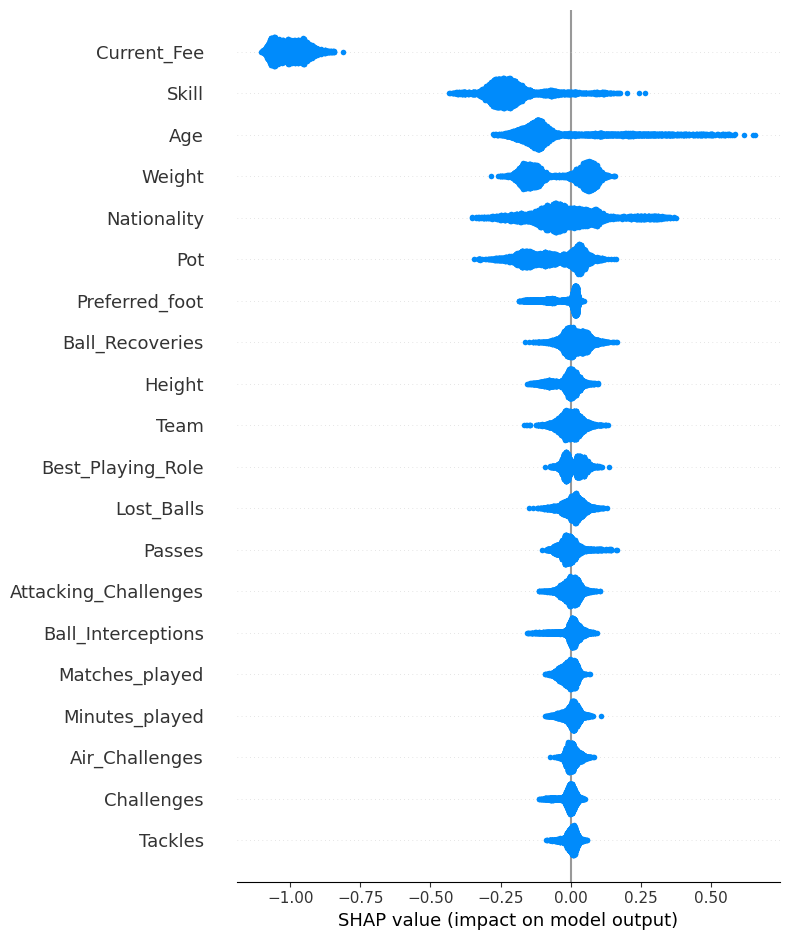

In [28]:
shap.summary_plot(shap_values, X.columns)

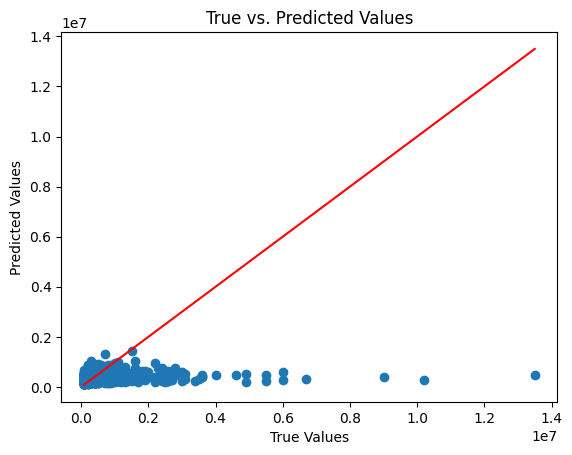

In [33]:
plt.scatter(y_test, pred_test)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()